# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array
import scipy.sparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run data_tools.ipynb

In [3]:
recbe_wiring_file = "/home/elg112/development/ICEDUST/track_finding_standalone/"+\
                    "track_finding_yandex/data/chanmap_20160814.root"
recbe_positions = root2array(recbe_wiring_file, selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19", 
                                        branches=["LayerID", "CellID","BoardID",
                                                  "BrdLayID", "BrdLocID","ChanID"])
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

# Signal Data

In [4]:
file_base = "/home/elg112/development/ICEDUST/track_finding_standalone/"\
            "track_finding_yandex/data/"
signal_files  = ["oa_xx_xxx_09100000-0000_opgjz6dop7ho_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09200000-0000_bxszqgjrri2n_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09400000-0000_7i52rtj3sz5v_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09600000-0000_xjij4zcypjul_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09800000-0000_b72ef5hzppor_user-TrkTree_000_signal-label.root",
                 "oa_xx_xxx_09900000-0000_orbwudhvihxn_user-TrkTree_000_signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_pdevedxn64ot_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09100000-0000_skzt2l7sdqvx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09200000-0000_x67rltrbhc3n_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09300000-0000_seae7w5z6fvt_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09400000-0000_o774i4trtmim_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09500000-0000_ufkycd74hb4i_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09600000-0000_arxgz3idch3j_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09700000-0000_5xz67bjkzokx_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09800000-0000_jrdukg5g2ivh_user-TrkTree_000_500signal-label.root",
                "oa_xx_xxx_09900000-0000_kgij2afd5rtp_user-TrkTree_000_500signal-label.root"]

signal_files = ["oa_xx_xxx_09000000-0000_qs4c2zivfkyl_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09100000-0000_k6i42km533k7_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09200000-0000_uuu3dtsod77t_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09300000-0000_2s4hlrntpcyh_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09400000-0000_vrw7y5jhefms_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09500000-0000_2xxlflqodbqq_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09600000-0000_ak6psvrdnn4v_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09700000-0000_bipfrfikeaqy_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09800000-0000_5w5tj34s5elw_user-TrkTree_000_700signal-label.root",
                "oa_xx_xxx_09900000-0000_diro4pagpbtt_user-TrkTree_000_700signal-label.root"]


back_files = ["batch_2_TrkTree_2500.root",
              "batch_3_TrkTree_2536.root",
              "batch_4_TrkTree_5250.root"]

signal_files = [ file_base + file_name for file_name in signal_files]
back_files   = [ file_base + file_name for file_name in back_files]

In [5]:
import root_numpy

In [6]:
pprint(root_numpy.list_branches(signal_files[0], treename="CTHHitTree"))

['CTHHit.fGoodTrack',
 'CTHHit.fGoodTrig',
 'CTHHit.fModule',
 'CTHHit.fCounter',
 'CTHHit.fIsSc',
 'CTHHit.fIsLG',
 'CTHHit.fNContrib',
 'CTHHit.fTrack.fTrackID',
 'CTHHit.fTrack.fParentTrackID',
 'CTHHit.fTrack.fPID',
 'CTHHit.fTrack.fTags.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsParent.fTagMaskPersisted',
 'CTHHit.fTrack.fTagsAsDaughter.fTagMaskPersisted',
 'CTHHit.fTrack.fStartMomentum.fX',
 'CTHHit.fTrack.fStartMomentum.fY',
 'CTHHit.fTrack.fStartMomentum.fZ',
 'CTHHit.fTrack.fStopMomentum.fX',
 'CTHHit.fTrack.fStopMomentum.fY',
 'CTHHit.fTrack.fStopMomentum.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fP.fX',
 'CTHHit.fTrack.fStartPosGlobal.fP.fY',
 'CTHHit.fTrack.fStartPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStartPosGlobal.fE',
 'CTHHit.fTrack.fStopPosGlobal.fP.fX',
 'CTHHit.fTrack.fStopPosGlobal.fP.fY',
 'CTHHit.fTrack.fStopPosGlobal.fP.fZ',
 'CTHHit.fTrack.fStopPosGlobal.fE',
 'CTHHit.fMCPos.fP.fX',
 'CTHHit.fMCPos.fP.fY',
 'CTHHit.fMCPos.fP.fZ',
 'CTHHit.fMCPos.fE',
 'CTHHit.fCharge',
 

In [7]:
these_branches = {}
these_branches["CDC"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]
these_branches["CTH"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]

In [8]:
train_s = data_import_sample(signal_files[0], back_files[0], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
test_s = data_import_sample(signal_files[1], back_files[1], 
                      these_cuts=["Trig","Track","700"],
                      branches=these_branches)
train_s.cth.set_trigger_time()
test_s.cth.set_trigger_time()
data_remove_coincidence(train_s)
data_remove_coincidence(test_s)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Signal Events
CTH Sig Events 2491 
CTH Back Events 2491 
CDC Sig Events 2491 
CDC Back Events 2491 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': [

In [150]:
print len(test_s_evt_samp[0]), len(evt_samp[0]) 

2241 2241


In [9]:
train_s.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CDC Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


## Define Training Sample For Track Finding

In [10]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [14]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train_s.cdc.n_events)
sample_1, sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
evt_samp       = [ np.sort(sample_1), np.sort(sample_2) ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_s.cdc)

In [15]:
# Get samples
# TODO clean me up a lot
test_s_rest = range(test_s.cdc.n_events)
test_s_sample_1, test_s_sample_2 = train_test_split(test_s_rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
test_s_evt_samp       = [ np.sort(test_s_sample_1), np.sort(test_s_sample_2) ]
test_s_evt_samp_masks, test_s_hit_masks = reset_masks(test_s_evt_samp, test_s.cdc)

# Look at features

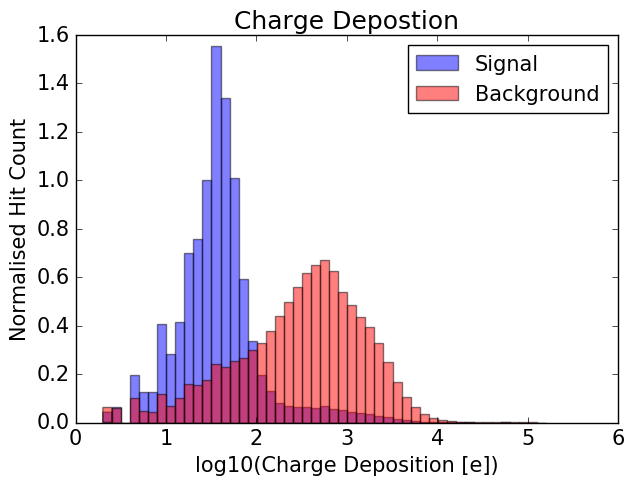

In [160]:
figsize(7, 5)
bins_for_plots = 50
plot_feature( np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] + 1), 
              np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion",
              nbins=bins_for_plots)
show()

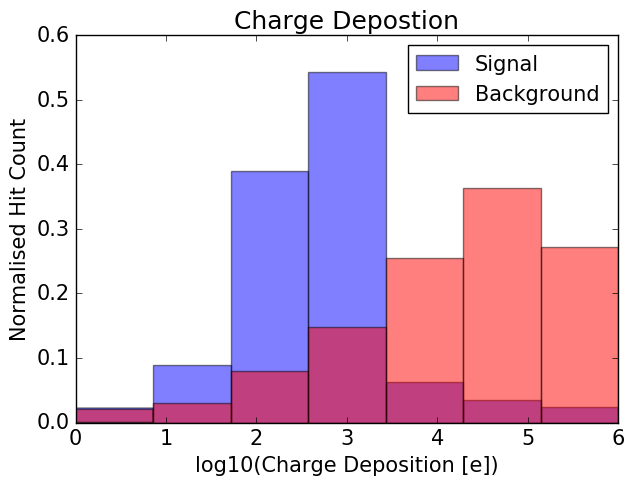

In [163]:
bins_for_plots = 50
powered_bins = np.array([3.150, 
                         10.000, 31.50,
                         100.00, 315.0,
                         1000.0])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=7,
              uniform_bins=False)
show()

In [ ]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=3,
              uniform_bins=False)
show()

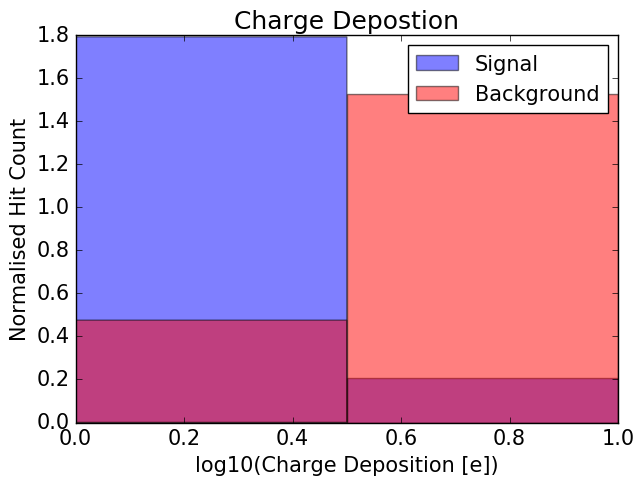

In [152]:
bins_for_plots = 50
plot_feature( np.digitize(np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              np.digitize(np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=2,
              uniform_bins=False)
show()

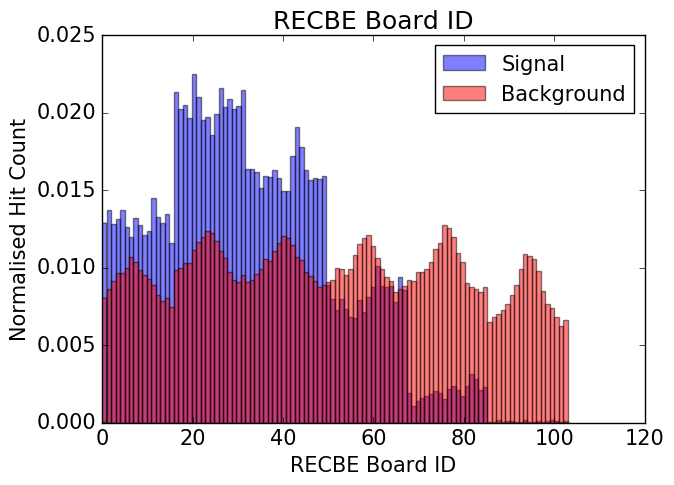

In [156]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature(recbe_positions["BoardID"][train_s.cdc.get_signal_hits()[train_s.cdc.flat_name]],
             recbe_positions["BoardID"][train_s.cdc.get_background_hits()[train_s.cdc.flat_name]], 
              xlabel="RECBE Board ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="RECBE Board ID", 
              nbins=104,
              uniform_bins=False)
show()

Sig Occ: 79.3679207921 , Back Occ : 491.190891089
All Occ: 570.558811881, 0.127300047274
NumHits: 570.558811881
MinChansMultiHit: 0.0


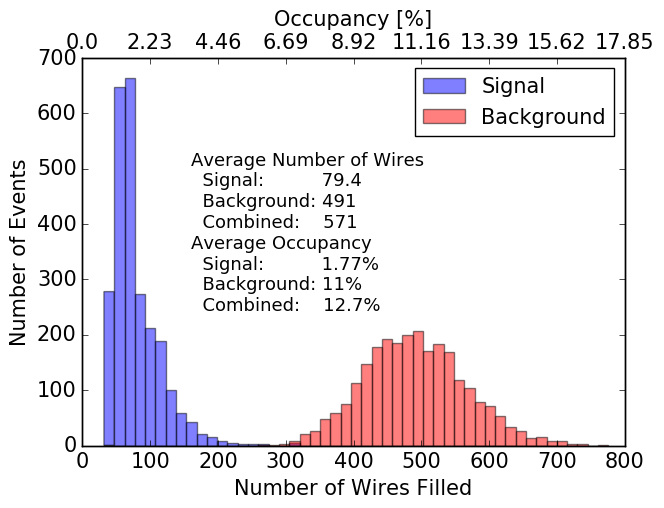

In [143]:
figsize(7,5)
sig_occ, back_occ, occ = data_get_occupancy(test_s.cdc) 
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.2, y_pos=0.76)

## Define Wire Features 

In [19]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [20]:
# Define Data
energy_feature = "Energy"
binary_energy = energy_feature + "_one_bit"
binned_energy = energy_feature+ "_two_bit"
high_bin_energy = energy_feature+ "_three_bit"
energy_feature = energy_feature + "_unbin"
board_id = "RECBE_id"
board_layer = "RECBE_layer"
layer_id = "Layer_ID"

binary_wire_features = [binary_energy, 
                        binary_energy + "_left",
                        binary_energy + "_right"]
binned_wire_features = [binned_energy, 
                        binned_energy + "_left",
                        binned_energy + "_right"]
high_bin_wire_features = [high_bin_energy, 
                          high_bin_energy + "_left",
                          high_bin_energy + "_right"]
unbin_wire_features = [energy_feature, 
                       energy_feature + "_left",
                       energy_feature + "_right"]
all_features = binary_wire_features + \
               binned_wire_features + \
               high_bin_wire_features + \
               unbin_wire_features + \
               [board_id, board_layer, layer_id]

In [21]:
factory = ClassifiersFactory()

# Define GBDT for ADC
binary_energy = SklearnClassifier(GradientBoostingClassifier(n_estimators=100),
                                  features=[energy_feature])
factory.add_classifier('ADC', binary_energy)
# Define GBDT for 1 bits
binary_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binary_wire_features + [board_id])
factory.add_classifier('Binary', binary_neighs)
# Define GBDT for 2 bits
binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=binned_wire_features + [board_id])
factory.add_classifier('Binned', binned_neighs)
# Define GBDT for 2 bits
high_binned_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=high_bin_wire_features + [board_id])
factory.add_classifier('High_Binned', high_binned_neighs)
# Define GBDT over unbinned wire features
unbin_neighs = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                 features=unbin_wire_features + [layer_id])
factory.add_classifier('Unbinned', unbin_neighs)

In [22]:
print train_s.cdc.n_hits, train_s.cdc.n_events
print train_s.cdc.get_measurement(train_s.cdc.hit_type_name).shape

1428895 2491
(1428895,)


In [23]:
def get_data_frame(samp, events):
    flat_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=events).astype(int)
    return DataFrame(np.vstack(
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[100], default=1) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1, 31.5, 100], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1.0000, 3.150, 
                                                                           10.000, 31.50,
                                                                           100.00, 315.0,
                                                                           1000.0], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events) +\
                        [recbe_positions["BoardID" ][flat_ids]] +\
                        [recbe_positions["BrdLayID"][flat_ids]] +\
                        [samp.cdc.geom.get_layers(flat_ids)]).T, columns=all_features)

In [24]:
# Train the classifier
factory.fit(get_data_frame(train_s, evt_samp[0]),
            train_s.cdc.get_measurement(train_s.cdc.hit_type_name, events=evt_samp[0]))

model ADC          was trained in 89.43 seconds
model Binary       was trained in 99.82 seconds
model Binned       was trained in 120.16 seconds
model High_Binned  was trained in 115.97 seconds
model Unbinned     was trained in 156.68 seconds
Totally spent 582.06 seconds on training


ClassifiersFactory([('ADC',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   presort='auto', random_state=None, subsample=1.0, verbose=0,
                                   warm_start=False),
                              features=['Energy_unbin'])),
                    ('Binary',
                     SklearnClassifier(clf=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
                                   max_depth=3, max_features=None, max_leaf_nodes=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
    

In [25]:
# Test the classifier
bbdt_diagnostics = \
    factory.test_on(get_data_frame(test_s, test_s_evt_samp[0]), 
                    test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0]))

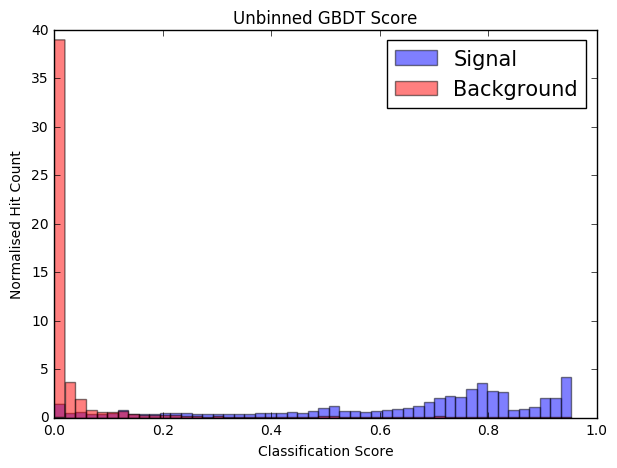

In [177]:
bins_for_plots = 50
plot_feature( bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 1.0,1],
              bbdt_diagnostics.prediction["Unbinned"][bbdt_diagnostics.target == 0.0,1],
              xlabel="Classification Score", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Unbinned GBDT Score", 
              nbins=bins_for_plots,
              uniform_bins=True)
show()

ADC
  0.847018854972
  (3, 9824)
Binary
  0.915736617838
  (3, 333)
Binned
  0.966858927642
  (3, 882)
High_Binned
  0.967466551732
  (3, 2739)
Unbinned
  0.971080873998
  (3, 82244)
{'ADC': 0.5601205897026692,
 'Binary': 0.32832015719151131,
 'Binned': 0.50257112804681237,
 'High_Binned': 0.49930901060647581,
 'Unbinned': 0.49143036705295429}


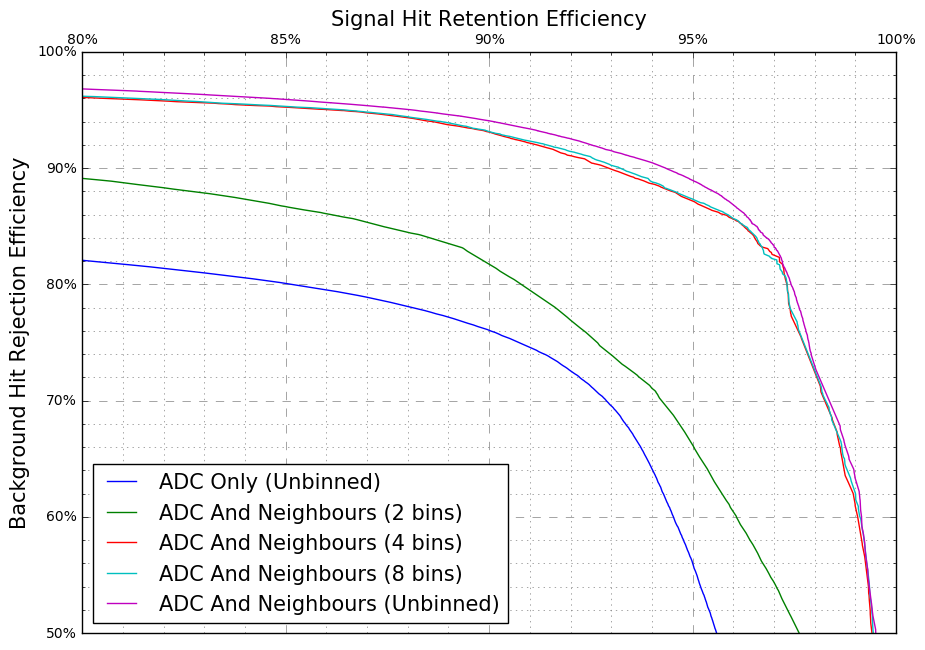

In [171]:
f_size = 10
plot_set_font(size=f_size)
figsize(7*1.5, 5*1.5)
curve_dict = dict()

cla_dict = {}
cla_dict["ADC"] = "ADC Only (Unbinned)"
cla_dict["Binary"] = "ADC And Neighbours (2 bins)"
cla_dict["Binned"] = "ADC And Neighbours (4 bins)"
cla_dict["High_Binned"] = "ADC And Neighbours (8 bins)"
cla_dict["Unbinned"] = "ADC And Neighbours (Unbinned)"
threshold_dict = {}


for cla in factory.keys():
    pred = None
    if cla == "ADC":
        pred =  1.0/np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics.prediction[cla][:,1]
    plot_roc_curve(bbdt_diagnostics.target, 
                   pred,
                   label=cla_dict[cla],
                   zoom=True,
                   zoom_x_lims=[80,100],
                   zoom_y_lims=[50,100],
                   datum_label="Hit")

    print cla
    print "  {}".format(roc_auc_score(bbdt_diagnostics.target, 
                                      pred))
    curve = roc_curve(bbdt_diagnostics.target,
                                pred)
    print "  {}".format(np.array(curve).shape)
    curve_dict[cla] = curve
    threshold_dict[cla] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]

pprint(threshold_dict)
plt.show()

### New Plot

Need (percentage of signal hits by event,
      percentage of background hits by event,
      score) 

Have (total signal hits,
      total background hits
      score)

In [83]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types_1 = all_types[beg_hits:end_hits]
    hit_types_2 = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt)
    #print beg_hits, end_hits
    if not np.array_equal(hit_types_1, hit_types_2):
        print evt
        print "  {} {}".format(hit_types_1.shape, hit_types_2.shape)
        print "  {} {}".format(sum(hit_types_1 == 0.0), sum(hit_types_2 == 0.0))
        print "  {} {}".format(sum(hit_types_1 == 1.0), sum(hit_types_2 == 1.0))
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [84]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types = all_types[beg_hits:end_hits]
    same = np.array_equal(hit_types, 
                          test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt))
    if not same:
        print evt, sum(hit_types==1), sum(hit_types==0), beg_hits, end_hits
    else:
        hit_types[hit_types==1] = 1./sum(hit_types==1)
        hit_types[hit_types==0] = 1./sum(hit_types==0)
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [85]:
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    vals, index, counts =  np.unique(all_types[beg_hits:end_hits], 
                                     return_counts=True, return_index=True)
    if np.unique(np.round(vals*counts).astype(int))[0] != 1:
        print evt
    beg_hits += test_s.cdc.event_to_n_hits[evt]

ADC Only (Unbinned) event weight
  0.842171426564
  (3, 14681)
ADC And Neighbours (2 bins) event weight
  0.916889939905
  (3, 333)
ADC And Neighbours (4 bins) event weight
  0.966578834795
  (3, 882)
ADC And Neighbours (8 bins) event weight
  0.967286509254
  (3, 2756)
ADC And Neighbours (Unbinned) event weight
  0.970928173897
  (3, 111377)
{'ADC': 0.5601205897026692,
 'ADC_Evt_W': 0.5557591642691968,
 'Binary': 0.32832015719151131,
 'Binary_Evt_W': 0.32868921690084313,
 'Binned': 0.50257112804681237,
 'Binned_Evt_W': 0.48422430726165755,
 'High_Binned': 0.49930901060647581,
 'High_Binned_Evt_W': 0.4870169302520998,
 'Unbinned': 0.49143036705295429,
 'Unbinned_Evt_W': 0.48016091400338928}


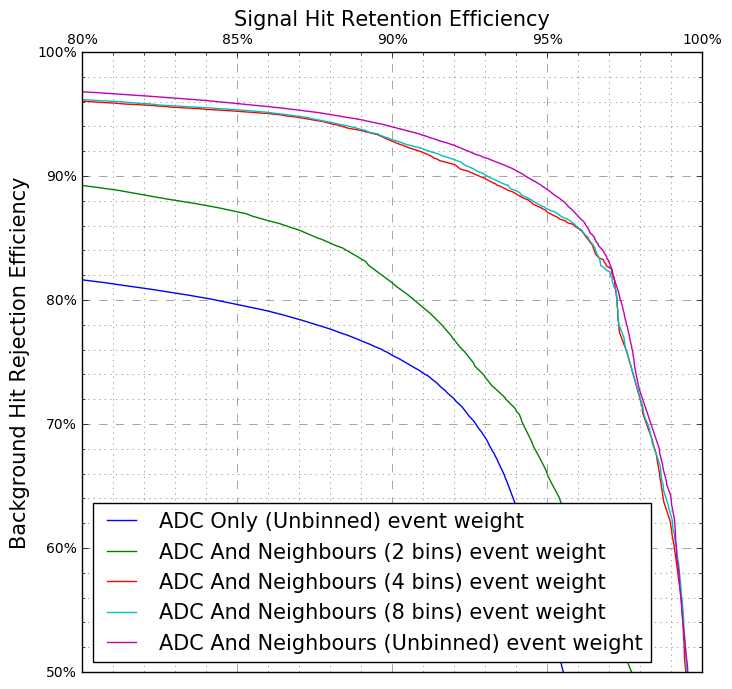

In [86]:
for cla in factory.keys():
    pred = None
    if cla == "ADC":
        pred =  1.0/np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics.prediction[cla][:,1]
    cla_label = cla_dict[cla] + " event weight"
    plot_roc_curve(bbdt_diagnostics.target, 
                   pred,
                   label=cla_label,
                   zoom=True,
                   zoom_x_lims=[80,100],
                   zoom_y_lims=[50,100],
                   datum_label="Hit",
                   weights=all_types)

    print cla_label
    print "  {}".format(roc_auc_score(bbdt_diagnostics.target, pred, sample_weight=all_types))
    curve = roc_curve(bbdt_diagnostics.target, pred, sample_weight=all_types)
    print "  {}".format(np.array(curve).shape)
    curve_dict[cla+"_Evt_W"] = curve
    threshold_dict[cla+"_Evt_W"] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]

pprint(threshold_dict)
plt.show()

In [87]:
#train_s.cdc.data[train_s.cdc.prefix+pos[2]] = - (train_s.cdc.data[train_s.cdc.prefix+pos[2]]/10. - 765)
#train_s.cdc.data[train_s.cdc.prefix+pos[1]] = train_s.cdc.data[train_s.cdc.prefix+pos[1]]/10.
#train_s.cdc.data[train_s.cdc.prefix+pos[0]] = (train_s.cdc.data[train_s.cdc.prefix+pos[0]]/10. - 641)
#train_s.cth.data[train_s.cth.prefix+pos[2]] = - (train_s.cth.data[train_s.cth.prefix+pos[2]]/10. - 765)
#train_s.cth.data[train_s.cth.prefix+pos[1]] = train_s.cth.data[train_s.cth.prefix+pos[1]]/10.
#train_s.cth.data[train_s.cth.prefix+pos[0]] = (train_s.cth.data[train_s.cth.prefix+pos[0]]/10. - 641)

In [114]:
pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train_s.cdc.prefix + pos[2]
p["cdc"]["y"] =  train_s.cdc.prefix + pos[1]
p["cdc"]["z"] =  train_s.cdc.prefix + pos[0]
p["cth"] = dict()
p["cth"]["x"] =  train_s.cth.prefix + pos[2]
p["cth"]["y"] =  train_s.cth.prefix + pos[1]
p["cth"]["z"] =  train_s.cth.prefix + pos[0]

data was predicted by ADC          in 0.00 seconds
data was predicted by Binary       in 0.00 seconds
data was predicted by Binned       in 0.00 seconds
data was predicted by High_Binned  in 0.00 seconds
data was predicted by Unbinned     in 0.00 seconds
Totally spent 0.01 seconds on prediction


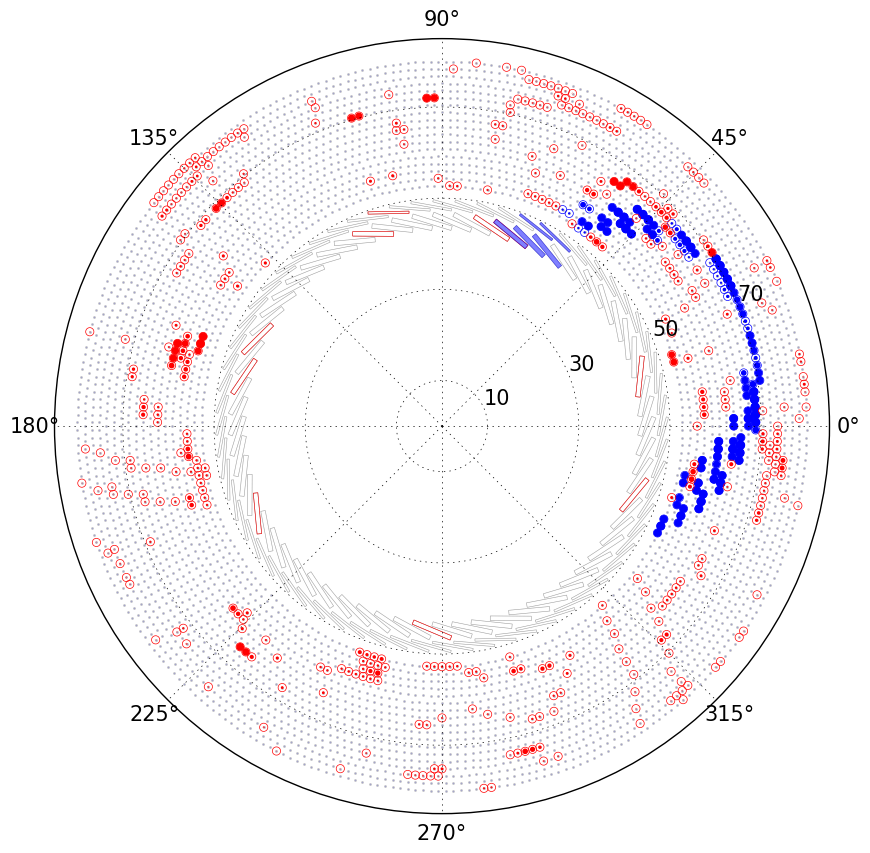

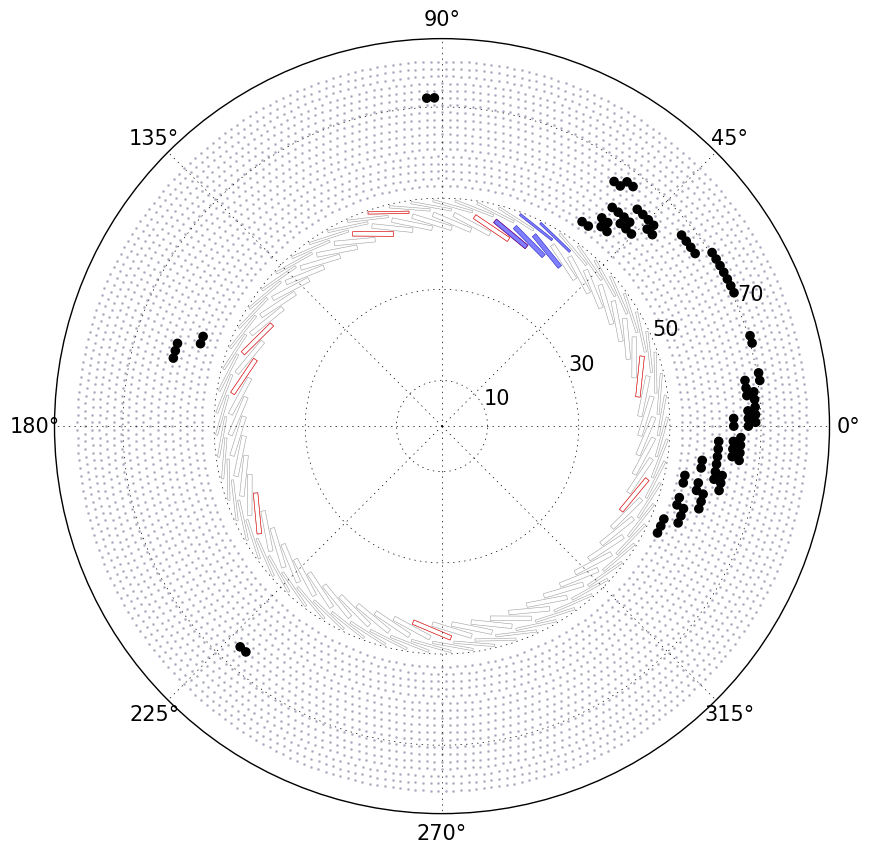

data was predicted by ADC          in 0.00 seconds
data was predicted by Binary       in 0.00 seconds
data was predicted by Binned       in 0.00 seconds
data was predicted by High_Binned  in 0.00 seconds
data was predicted by Unbinned     in 0.00 seconds
Totally spent 0.01 seconds on prediction


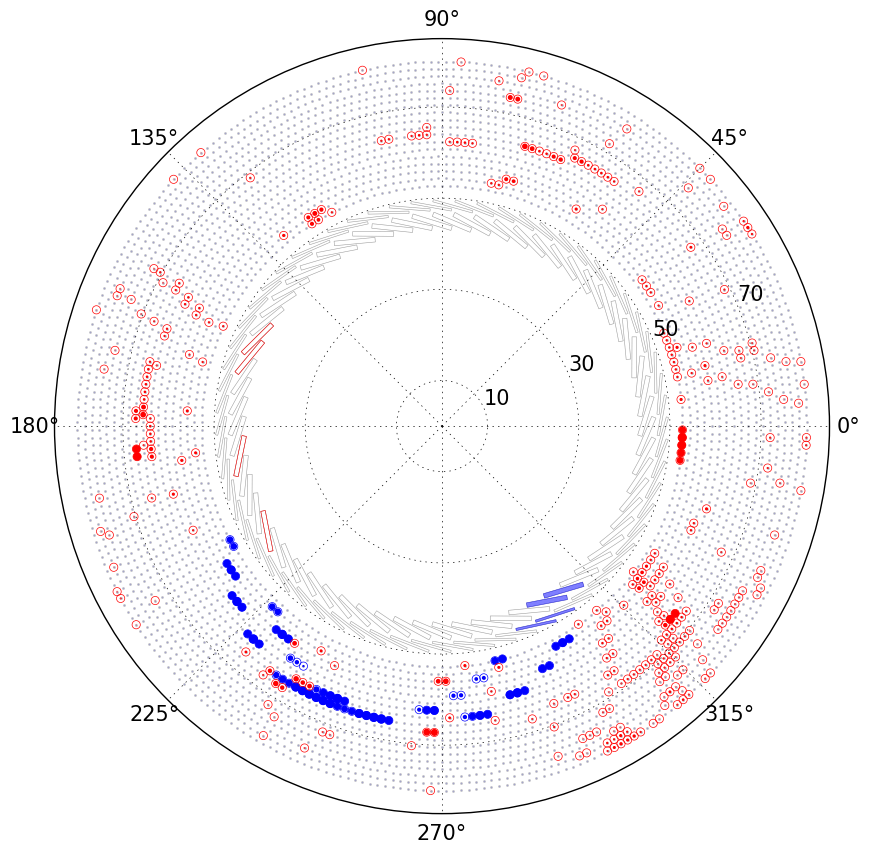

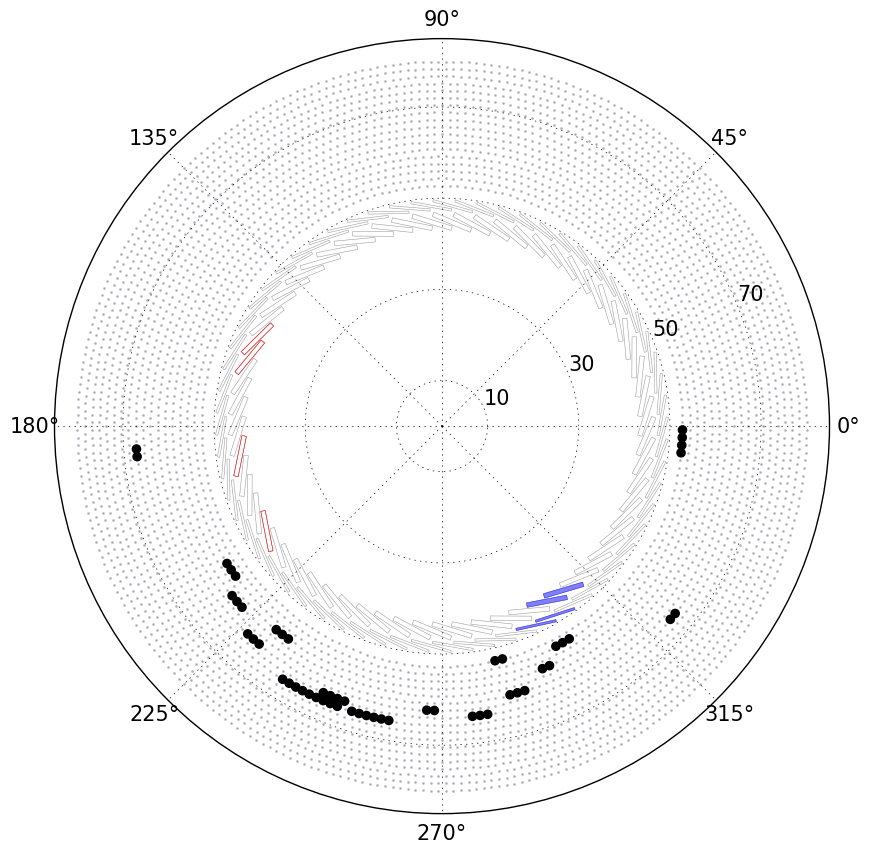

data was predicted by ADC          in 0.00 seconds
data was predicted by Binary       in 0.00 seconds
data was predicted by Binned       in 0.00 seconds
data was predicted by High_Binned  in 0.00 seconds
data was predicted by Unbinned     in 0.00 seconds
Totally spent 0.01 seconds on prediction


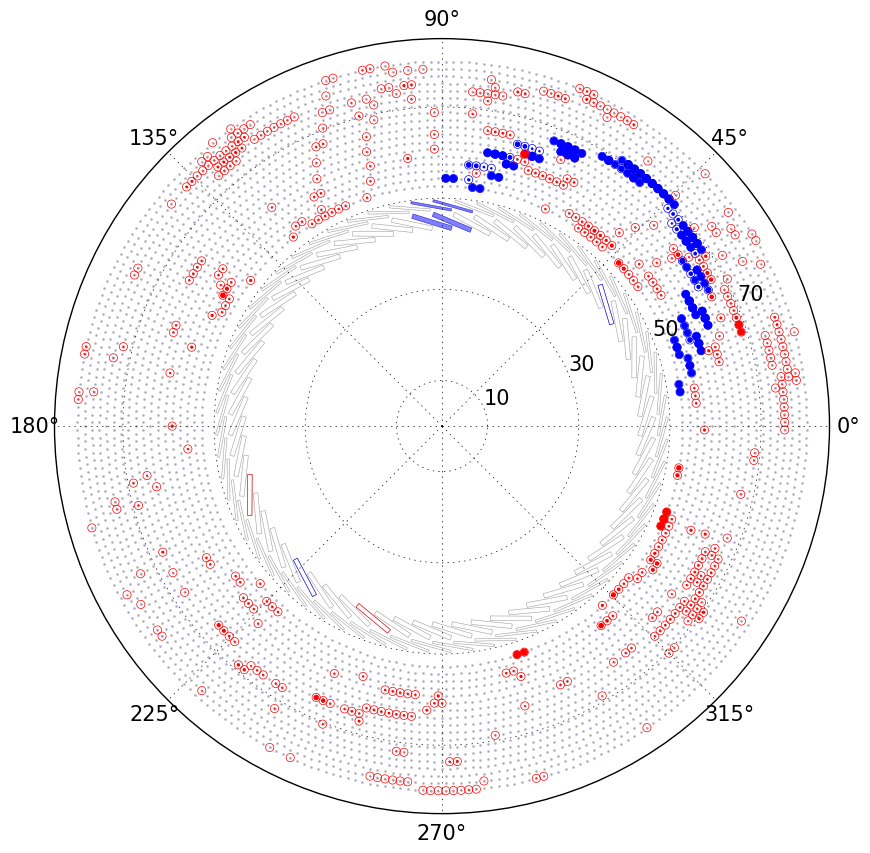

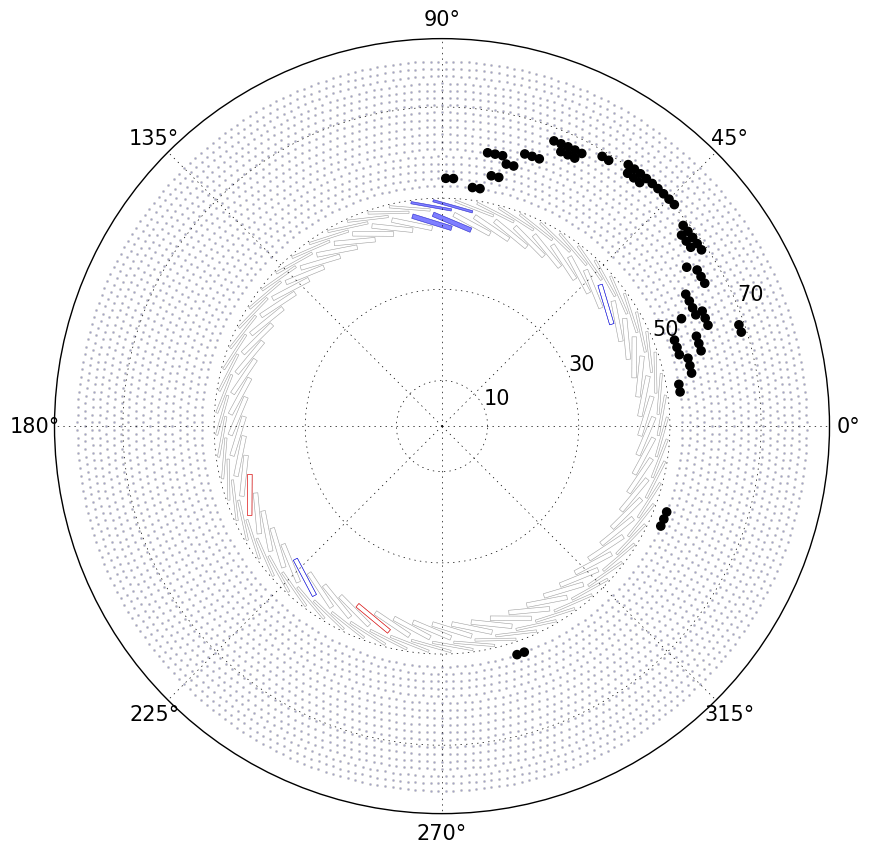

In [170]:
classifier = "Binned"
fig_s = (10,10)
s_scale = 35
plot_recbes = True
for evt in range(1775,1778):
    # Plot the output
    output = np.zeros(4482)
    geom_ids = test_s.cdc.get_measurement(test_s.cdc.flat_name, evt).astype(int)
    output[geom_ids] = factory.predict_proba(get_data_frame(test_s, evt))[classifier][:,1]
    cut = (output >= threshold_dict[classifier])

    for output, outline in zip([output, cut], [True,False]): 
        if not outline:
            plot_output(test_s.cdc.get_hit_types(evt),
                                      test_s.cdc.geom, size=output*s_scale, figsize=fig_s,
                        sig_color="Black", bkg_color="Black")
        # Add hit outlines
        if outline:
            plot_output(test_s.cdc.get_hit_types(evt),
                                      test_s.cdc.geom, size=output*s_scale, figsize=fig_s)
            plot_add_outlines(test_s.cdc.get_hit_types(evt), 
                              test_s.cdc.geom, size=s_scale)
        # Add volume outlines
        plot_add_cth_outlines(test_s.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = test_s.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, test_s.cth.get_trig_vector(evt)[0], test_s.cth.geom)
        cth_hits = test_s.cth.get_events(evt)
        cdc_hits = test_s.cdc.get_events(evt)
        plt.scatter(cth_hits[p["cth"]["x"]], 
                    cth_hits[p["cth"]["y"]], 
                    s=1, transform=gca().transData._b)
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)
        plt.show()
    print "====================================================================="

## Examine the Boards

RECBE Level Classification:

* Features:
    * Sum of Scores (L/R)
    * Number of wires (L/R)
    * Layer ID
* Approaches:
    * Number of boards above threshold
    * Shape-based analysis
* Unused data:
    * Information from CTH trigger

In [116]:
board_evt_scores = OrderedDict()
for event in test_s_evt_samp[0]:
    board_evt_scores = 
board_evt_to_hits = np.zeros((np.amax(test_s_evt_samp[0]), n_boards))
first_hit = 0
last_hit = 0
for new_evt, old_evt in enumerate([:10]):
    first_hit = last_hit
    last_hit += test_s.cdc.event_to_n_hits[old_evt]
    board_evt_to_hits[]

SyntaxError: invalid syntax (<ipython-input-116-3b2d86429dba>, line 3)

In [117]:
n_boards = np.unique(recbe_positions["BoardID"]).shape

In [118]:
recbe_values = OrderedDict()
for r_evt, evt in enumerate(test_s_evt_samp[0]):
    flat_ids  = samp.cdc.get_measurement(samp.cdc.flat_name, events=evt).astype(int)
    board_ids = recbe_positions["BoardID"][flat_ids]
    n_boards[r_evt, board_ids] += samp.cdc.get_measurement(samp.cdc., events=evt).astype(int)

SyntaxError: invalid syntax (<ipython-input-118-4737a18a0314>, line 5)

In [119]:
recbe = OrderedDict()
recbe["events"] = 

SyntaxError: invalid syntax (<ipython-input-119-2a49a43a8304>, line 2)

## Import Event Sample

In [120]:
sig_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)
bck_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","700"],
                              branches=these_branches)

Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Background Events
CTH Sig Events 3419 
CTH Back Events 3419 
CDC Sig Events 3419 
CDC Back Events 3419 
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 700',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 700'}
Getting branches
{'CDC

In [121]:
bck_evts.cdc.trim_hits(sig_evts.cdc.hit_type_name, values=[False])

In [122]:
sig_evts.cth.set_trigger_time()
bck_evts.cth.set_trigger_time()

In [123]:
data_remove_coincidence(sig_evts)
data_remove_coincidence(bck_evts)

### Classify Event Sample

In [124]:
evt_scores = {}
evt_scores["Signal"] = {}
evt_scores["Background"] = {}

In [125]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print etype, cla
        evt_scores[etype][cla] = np.array([sum(factory[cla].predict_proba(get_data_frame(samp, evt))[:,1])
                                           for evt in range(samp.cdc.n_events)])

Signal ADC
Signal Binary
Signal Binned
Signal High_Binned
Signal Unbinned
Background ADC
Background Binary
Background Binned
Background High_Binned
Background Unbinned


In [126]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print etype, cla
        evt_scores[etype][cla+"_cut"] = np.array([sum(factory[cla].predict_proba(get_data_frame(samp, evt))[:,1])
                                           for evt in range(samp.cdc.n_events)])

Signal ADC
Signal Binary
Signal Binned
Signal High_Binned
Signal Unbinned
Background ADC
Background Binary
Background Binned
Background High_Binned
Background Unbinned


In [127]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    print etype, cla
    evt_scores[etype]["ADC_2"] = np.array([sum((samp.cdc.get_measurement(samp.cdc.edep_name, 
                                                                         events=evt)) < 100.0)
                                           for evt in range(samp.cdc.n_events)])

Signal Unbinned
Background Unbinned


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2d3bbebcd0>,
 <matplotlib.figure.Figure at 0x7f2d3b64fa10>)

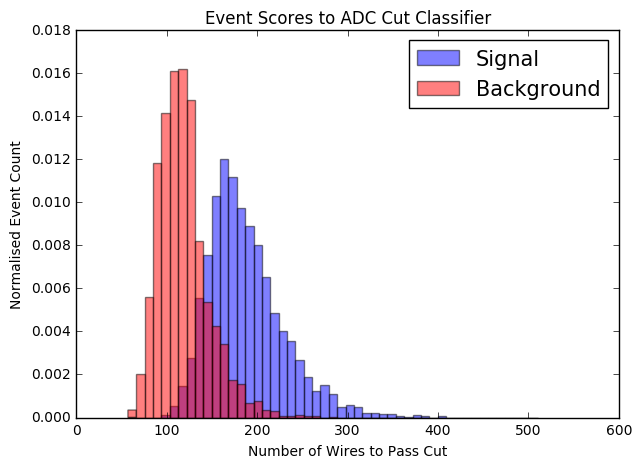

In [174]:
figsize(7,5)
plot_feature( evt_scores["Signal"]["ADC_2"], 
              evt_scores["Background"]["ADC_2"], 
              xlabel="Number of Wires to Pass Cut", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to ADC Cut Classifier", 
              nbins=bins_for_plots)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2d3bb558d0>,
 <matplotlib.figure.Figure at 0x7f2d3b580150>)

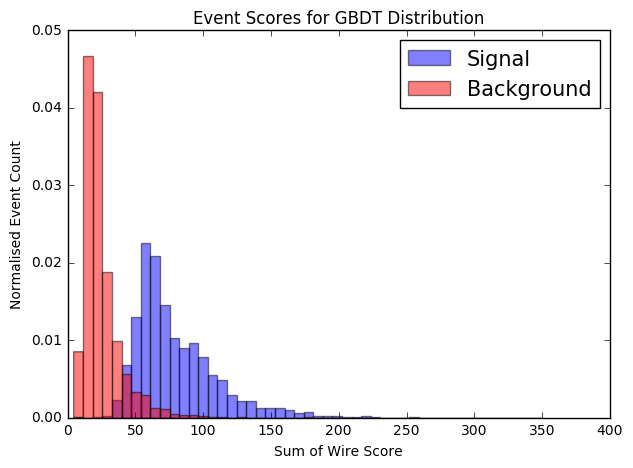

In [175]:
plot_feature( evt_scores["Signal"]["Unbinned"], 
              evt_scores["Background"]["Unbinned"], 
              xlabel="Sum of Wire Score", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores for GBDT Distribution", 
              nbins=bins_for_plots)

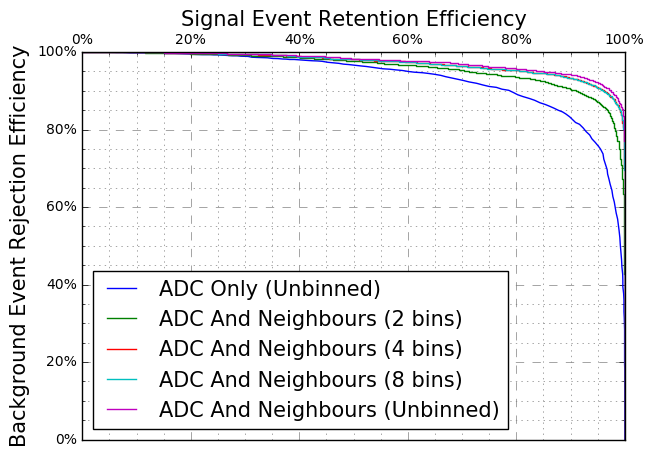

In [178]:
labels = np.zeros(sig_evts.cdc.n_events + bck_evts.cdc.n_events)
labels[:sig_evts.cdc.n_events] = 1
plot_roc_curve(labels, np.append(evt_scores["Signal"]["ADC_2"],  
                                 evt_scores["Background"]["ADC_2"]),
                                 label="ADC Only (Unbinned)", zoom=False,
                                 zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                                 datum_label="Event")
for cla in factory.keys():
    if cla == "ADC": continue
    plot_roc_curve(labels, np.append(evt_scores["Signal"][cla],  
                                     evt_scores["Background"][cla]),
                                     label=cla_dict[cla], zoom=False,
                                     zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                                     datum_label="Event")
plt.show()